<h1 style="color:green; font-family:Georgia">
Machine Learning for MNIST Handwritten digit recognition with PyTorch ::
<hr>
</h1>

<span style = "font-family:Geogia; color:orange;  font-style:italic; font-size:14px">
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.<br>

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%<br>
</span>

<h5 style="color:red; font-family:Georgia">
total number of images (instances): 70000 <br>
total number of features: 784 (28$\times$28 pixels = 784)
</h5>


For reference of each step see: https://chatgpt.com/share/66ffe9c1-5f98-8013-83b4-e797970250ab

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Importing importent modules :
</h4>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from Curve_fitting_with_scipy import Linefitting as Lf
from scipy.signal import fftconvolve
from collections import defaultdict
import PIL
import joblib



from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression



from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier, XGBRFRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transformers
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Getting the data :
</h4>

In [16]:
file_path_train = "D:\\ML Dataset\\MNIST csv\\mnist_train.csv"
file_path_test = "D:\\ML Dataset\\MNIST csv\\mnist_test.csv"
# Read the CSV file into a DataFrame
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

shuffled_index = np.random.permutation(data_train.shape[0])
data_train = data_train.iloc[shuffled_index]
del shuffled_index
print(data_train.shape)

(60000, 785)


<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Separating out features and labels:
</h4>

In [32]:
x_train=data_train.drop("label", axis=1)
y_train=data_train["label"]

x_test=data_test.drop("label",axis=1)
y_test=data_test["label"]

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Preprocessing with sklearn for imputing and scaling
</h4>

In [18]:
pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy='median')),
                    ('std_scalar',StandardScaler()),
                     # add as many as you want...
                    ])

x_train = pipeline.fit_transform(x_train)
x_test = pipeline.fit_transform(x_test)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Defining the neural network class:
</h4>

In [19]:
# Define the model with 15 fully connected layers
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define 15 fully connected layers
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        
        # Output layer for 10 classes (digits 0-9)
        self.out = nn.Linear(128, 10)


    def forward(self, x):
        # Flatten the input (28x28) to a vector (784)
        x = x.view(-1, 784)
        
        # Apply different activation functions between each layer
        x = F.relu(self.fc1(x))        # ReLU activation for layer 1
        x = F.relu(self.fc2(x))        # Leaky ReLU for layer 2
        x = F.relu(self.fc3(x))        # Tanh activation for layer 3
        
        # Output layer (for classification, we'll apply log softmax)
        x = F.softmax(self.out(x), dim=1)
        s
        return x

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Defining the parameters and learning rates for the neural network:
</h4>

In [20]:
# Hyperparameters
batch_size = 400
learning_rate = 0.0005
epochs = 10


# Initialize the model, loss function and optimizer
model = FullyConnectedNN()
# model = model.double()  # Convert model parameters to Double
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Use this DataLoader format if needed. This will take the train and test data without separating the features and labels.
</h4>

In [21]:
# class CustomDataset(Dataset):
#     def __init__(self, x_data, y_data):
#         self.x_data = x_data
#         self.y_data = y_data

#     def __len__(self):
#         return len(self.x_data)

#     def __getitem__(self, idx):
#         return self.x_data[idx], self.y_data[idx]

# # Create instances of the custom dataset for training and testing
# train_dataset = CustomDataset(x_train, y_train)
# test_dataset = CustomDataset(x_test, y_test)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# # Modified Training loop
# def train(model, device, train_loader, optimizer, criterion, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         output = model(data)
        
#         # Calculate loss
#         loss = criterion(output, target)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         # Print progress
#         if batch_idx % 100 == 0:
#             print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
#                   f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# # Modified Test loop
# def test(model, device, test_loader, criterion):
#     model.eval()  # Set the model to evaluation mode
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():  # Disable gradient computation for testing
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            
#             # Forward pass
#             output = model(data)
            
#             # Sum up batch loss
#             test_loss += criterion(output, target).item()
            
#             # Get the index of the max log-probability (prediction)
#             pred = output.argmax(dim=1, keepdim=True)
            
#             # Count correct predictions
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     # Print test results
#     test_loss /= len(test_loader.dataset)
#     print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
#           f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

# # Training the model
# for epoch in range(1, epochs + 1):
#     train(model, device, train_loader, optimizer, criterion, epoch)
#     test(model, device, test_loader, criterion)


<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Defining the train, test and evaluate functions for the model learning
</h4>

In [22]:
def train(model, device, x_train, y_train, optimizer, criterion, batch_size, epoch):
    model.train()
    num_samples = x_train.size(0)
    
    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        data = x_train[batch_start:batch_end].to(device).float()
        target = y_train[batch_start:batch_end].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print progress
        if batch_start % (100 * batch_size) == 0:
            print(f'Train Epoch: {epoch} [{batch_start}/{num_samples} '
                  f'({100. * batch_start / num_samples:.0f}%)]\tLoss: {loss.item():.6f}')


def test(model, device, x_test, y_test, criterion, return_val=False):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    num_samples = x_test.size(0)
    all_predictions = []  # To store all predicted labels

    with torch.no_grad():  # Disable gradient computation for testing
        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            data = x_test[batch_start:batch_end].to(device).float()
            target = y_test[batch_start:batch_end].to(device)

            # Forward pass
            output = model(data)
            
            # Sum up batch loss
            test_loss += criterion(output, target).item()
            
            # Get the index of the max log-probability (prediction)
            pred = output.argmax(dim=1, keepdim=True)  # Shape: [batch_size, 1]
            all_predictions.append(pred.cpu().numpy())  # Store predictions
            
            # Count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Concatenate all predictions into a single array
    all_predictions = np.concatenate(all_predictions)

    # Print test results
    test_loss /= num_samples
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{num_samples} '
          f'({100. * correct / num_samples:.0f}%)\n')
    if return_val:
        return all_predictions
    else:
        pass

def model_evaluate(model=model, x_test=x_test, epochs=epochs):
    #model.__init__()
    # Training the model
    for epoch in range(1, epochs):
        train(model, device, x_train, y_train, optimizer, criterion, batch_size, epoch)
        test(model, device, x_test, y_test, criterion)

    train(model, device, x_train, y_train, optimizer, criterion, batch_size, epochs+1)
    y_predict = test(model, device, x_test, y_test, criterion, return_val=True)

    return y_predict
    

In [23]:
y_predict = model_evaluate(model, x_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302732
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.580097

Test set: Average loss: 0.0038, Accuracy: 9366/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.513914
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.543871

Test set: Average loss: 0.0038, Accuracy: 9525/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.495368
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.515449

Test set: Average loss: 0.0038, Accuracy: 9594/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.491218
Train Epoch: 4 [40000/60000 (67%)]	Loss: 1.510051

Test set: Average loss: 0.0037, Accuracy: 9633/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.481325
Train Epoch: 5 [40000/60000 (67%)]	Loss: 1.493694

Test set: Average loss: 0.0037, Accuracy: 9628/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.477837
Train Epoch: 6 [40000/60000 (67%)]	Loss: 1.483843

Test set: Average loss: 0.0037, Accuracy: 9665/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.476960
Train Epoch: 7 [400

<h4 style="color:orange; font-family:Georgia">
Showing the accuracy of the model for each digit differently...
</h4>

accuracy_score:  97.11 %


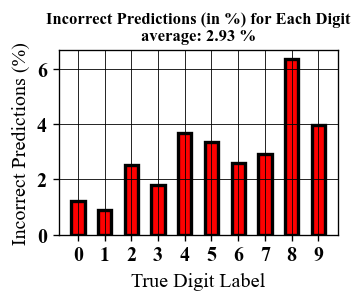

In [26]:
y_test_arr = np.array(y_test,dtype=np.float32)
y_predict = (np.array(y_predict)).reshape(y_test_arr.shape)

acc_score = accuracy_score(y_test_arr,y_predict)
print(f"accuracy_score:  {100*acc_score:.2f} %")

# Identify incorrect predictions
incorrect_indices = np.where(y_test_arr != y_predict)[0]
incorrect_labels = y_test[incorrect_indices]# Extract the corresponding true labels (y_test) for incorrect predictions
total_per_digit = np.bincount(sorted(y_test_arr), minlength=10) # Calculate the total occurrences of each digit in the test set
incorrect_per_digit = np.bincount(sorted(incorrect_labels), minlength=10)  # Calculate the incorrect occurrences for each digit
percentage_incorrect_per_digit = (incorrect_per_digit / total_per_digit) * 100  # Calculate the percentage of incorrect predictions for each digit

# Plot the percentage of incorrect predictions for each digit
plt.figure(figsize=(3,2))
plt.bar(np.arange(10), percentage_incorrect_per_digit, color='red', edgecolor='black', linewidth = 2, width=0.5)
plt.xticks(np.arange(10))  # Digits 0 to 9
plt.xlabel('True Digit Label')
plt.ylabel('Incorrect Predictions (%)')
plt.title('Incorrect Predictions (in %) for Each Digit\n'+f"average: {np.mean(percentage_incorrect_per_digit):.2f} %", fontsize=10, fontweight='bold')
plt.grid(True, lw=0.5, color = 'k')
plt.show()
